# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [5]:
import numpy as np
from scipy import optimize
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
#* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

Furthermore, we introduce $\tau$ as the bequest taxation rate $0<\tau<1$


In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+(1-\tau)\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

# Steady state

## Analytical solution

We can use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] $$

First we define all **symbols**:

In [32]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5
tau = tau

lav senere


## Defining value functions

In [24]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa,tau):
    return utility(c2,d2,alpha,rho) + (1-tau)*bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp,tau):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

We first define the solution function for period 2

In [45]:
def solve_period_2(alpha,rho,nu,kappa,Delta,tau):

    # a. grids
    m2_vec = np.linspace(1e-8,5,200)
    d2_vec = np.linspace(1e-8,5,200)
    v2_grid = np.empty((200,200))
    c2_grid = np.empty((200,200))
    v2_vecm = np.empty(200)
    c2_vecm = np.empty(200)
    v2_vecd = np.empty(200)
    c2_vecd = np.empty(200)
    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda c2: -v2(c2,d2,m2,alpha,rho,nu,kappa,tau)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x 
            
            v2_vecm = v2_grid[:,0]
            c2_vecm = c2_grid[:,0]
            
            v2_vecd = v2_grid[0,:]
            c2_vecd = c2_grid[0,:]
        
    return m2_vec,d2_vec,v2_grid,c2_grid,c2_vecm,v2_vecm,c2_vecd,v2_vecd

Solving for 2nd period

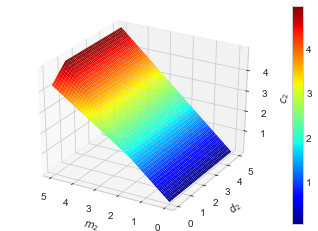

In [26]:
# a. solve
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta,tau)

# b. grids
m2_grid,d2_grid = np.meshgrid(m2_vec,d2_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d2_grid,c2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$c_2$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

NameError: name 'd2_vecd' is not defined

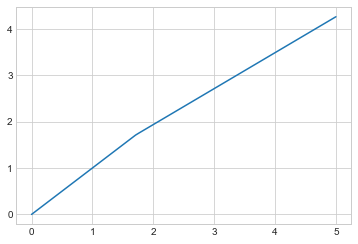

In [47]:
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp,tau):

    # a. grids
    m1_vec = np.linspace(1e-4,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp,tau)
        
        # ii. initial guess
        x0 = [m1*1/3,m1*1/3]
        
        # iii. bounds and constraitns
        bound = (1e-8,m1-1e-8)
        bounds = (bound, bound)
        ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]-x[1]} 
        
        # iv. optimize
        result = optimize.minimize(obj,x0, method='SLSQP',
                                   bounds=bounds,
                                   constraints=[ineq_con])
        
        #result = optimize.minimize(obj,x0, method='Nelder-Mead')
        
        # v. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
        d1_vec[i] = result.x[1]
     
    return m1_vec,v1_vec,c1_vec,d1_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d2_vec), v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
m1_vec,v1_vec,c1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp,tau)





m2_vec,d2_vec,v2_grid,c2_grid,c2_vecm,v2_vecm,c2_vecd,v2_vecd = solve_period_2(alpha,rho,nu,kappa,Delta,tau)


# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m2_vec,c2_vecm,label='non-durable consumption')
ax.plot(m2_vec,d2_vecd,label='durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

In [ ]:

m2_vec,d2_vec,v2_grid,c2_grid,c2_vecm,v2_vecm,c2_vecd,v2_vecd = solve_period_2(alpha,rho,nu,kappa,Delta,tau)


# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='non-durable consumption')
ax.plot(m1_vec,d1_vec,label='durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

and **solve** it

In [39]:
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta,tau)

type(c2_vec)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [33]:
taus = np.linspace(0,1,20)



for tau in taus:
    #solving for period 2
    m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta,tau)
    #solving for period 1
    m1_vec,v1_vec,c1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp,tau)
    


In [ ]:
Delta = 0.5
#solving for period 2
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta,tau)
#solving for period 1
m1_vec,v1_vec,c1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp,tau)

m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,Delta,nu,kappa)

c1_interp = interpolate.RegularGridInterpolator([m1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)

c2_interp = interpolate.RegularGridInterpolator([m2_vec], c2_vec,
                                                bounds_error=False,fill_value=None)

In [4]:
kss = sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

For later use, we turn the solution into a **Python funciton**

In [5]:
ss_func = sm.lambdify((s,g,n,alpha,delta),kss)

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [6]:
s = 0.2
g = 0.02
n = 0.01
alpha = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [7]:
solution = modelproject.solve_for_ss(s,g,n,alpha,delta)

print(f'analytical solution is: {ss_func(s,g,n,alpha,delta):.3f}')
print(f' numerical solution is: {solution.root:.3f}')

analytical solution is: 1.904
 numerical solution is: 1.904


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.